In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import random

In [11]:
import pathlib
pathlib.Path().resolve()

PosixPath('/content')

In [17]:
# Importing models and compiling them
#model = tf.keras.models.load_model(r'..\..\..\build\saved_model\VGG19_TransferLearning\HDF5\VGG19_TransferLearning.h5', compile=True)
model = tf.keras.models.load_model(r'/content/drive/Othercomputers/PC/msc_final_project/TPU/build/saved_model/VGG19_TransferLearning/HDF5/VGG19_TransferLearning.h5', compile=True)



# Show the model architecture
#model.summary()



## 1    Preparing and pre-processing data

In [18]:
# Utility functions
def print_shapes(train_images, test_images, train_labels, test_labels):
  print(f"train_images: {train_images.shape}\n"\
      f"test_images: {test_images.shape}\n"\
      f"train_labels: {train_labels.shape}\n"\
      f"test_labels: {test_labels.shape}\n")

In [19]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
print_shapes(train_images, test_images, train_labels, test_labels)

170508288/170498071 [==============================] - 11s 0us/step
train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 1)
test_labels: (10000, 1)



In [20]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10 
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

train_images = train_images / 255
test_images = test_images / 255

train_images = train_images.reshape((-1, height, width, channels))
test_images = test_images.reshape((-1, height, width, channels))

train_labels = tf.keras.utils.to_categorical(train_labels, nb_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, nb_classes)

print_shapes(train_images, test_images, train_labels, test_labels)

train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 10)
test_labels: (10000, 10)



## 2    Implementing the Fast Gradient Sign Method with Keras and TensorFlow

In [21]:
# Function to calculate adversary noise
def generate_adversary(image, label):
  '''Generates adversarial noise for a given image and label
  Args:
    image(np.array):  input image, shape like (1, height, width, channels)
    label(int): label of the image, shape like (nb_classes, )
  
  Returns:
    sign_grad(tf.Tensor): adversarial noise, should be changed to numpy array before add to the image.T
                          shape like (1, height, width, channels)
  '''

  # Change the image to a tensor
  image = tf.cast(image, tf.float32)

  #record gradients
  with tf.GradientTape() as tape:

    tape.watch(image)

    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
    
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

Prediction from VGG19: deer


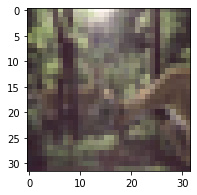

In [ ]:
# Selecting random image for testing
rand_idx = random.randint(0,49999)
#rand_idx = 6
image = train_images[rand_idx].reshape((1, height, width, channels))
label = train_labels[rand_idx]

print(f'Prediction from VGG19: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# A single test image
# Adding the adversary noise to image
perturbations = generate_adversary(image,label).numpy()
adversarial = image + (perturbations * 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


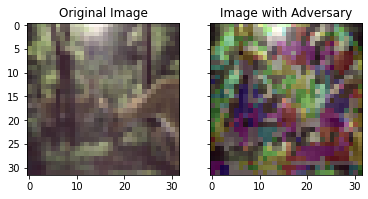

In [ ]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 412ms/step
Normal Image Prediction: frog
1/1 [==============================] - 0s 52ms/step
Adversary Prediction: frog


## 3    Let's try this out for different values of epsilon and observe the resultant image.

In [ ]:
def display_images(image, description):
  
  label = label_names[model(image).numpy().argmax()]

  
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {}'.format(description,label))
  plt.show()

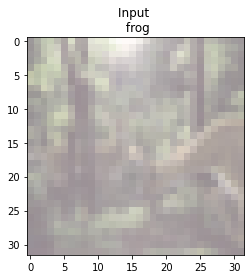

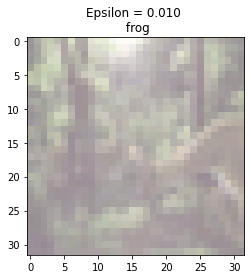

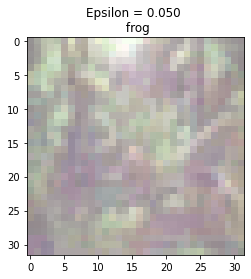

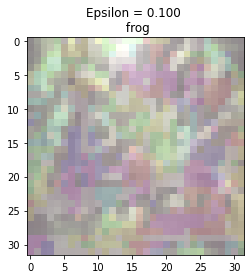

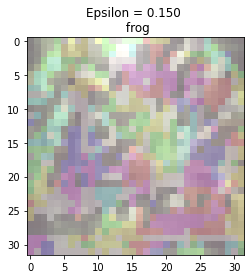

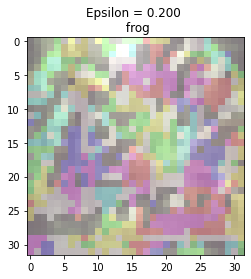

In [ ]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]


for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

## 4    create a adversary noise set and test the model right rate

In [30]:
# Function to calculate adversary noise
def generate_adversary_image(image, label, epsilon):

  '''Directly add the adversarial noise to the image

  Args:
    image: a image but need to be reshaped to  [1, height, width, channels]
    label: label from xxxx_labels[i]
           {array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}
           {numpy.ndarray}
    epsilon: int number of epsilon
             {1}


  Returns:
    A tensor of shape [1, height, width, channels]
  '''

  # Change the image to a tensor
  image_tf = tf.cast(image, tf.float32)

  #record gradients
  with tf.GradientTape() as tape:
    
    tape.watch(image_tf)

    prediction = model(image_tf)
    loss = tf.keras.losses.MSE(label, prediction)
    
  gradient = tape.gradient(loss, image_tf)
  sign_grad = tf.sign(gradient)
  sign_grad = sign_grad.numpy()

  adversarial = image + (sign_grad * epsilon)

  

  return adversarial

In [ ]:
'''
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
ax2.imshow(generate_adversary_image(image, label, 0.1).reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()
'''

'\nfig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)\nax1.imshow(image.reshape(height,width, channels))\nax1.set_title("Original Image")\nax2.imshow(generate_adversary_image(image, label, 0.1).reshape(height,width, channels))\nax2.set_title("Image with Adversary")\nplt.show()\n'

### 4.1 Use test_images for test

In [32]:
def create_adversarty_images_set(image_set, label_set, total_label, epsilon):
    '''A script to create adversarial images set

    Args:
        image_set: image set which need to be adversarized. shape like (len(image_set), height, width, channels)
        label_set: label set of the image set.  shape like (len(image_set), nb_classes)
        total_label: whole label set
        epsilon: int number of epsilon

    Returns:
        adversarial_images_set: adversarial images set. shape like (len(image_set), height, width, channels)
    '''


    right_count_original = 0
    right_count_adversary = 0

    for i in range(len(image_set)):
        image = image_set[i].reshape((1, height, width, channels))
        label = label_set[i]

        #label_name_original = total_label[np.where(label==1)[0][0]]
        label_original = np.where(label==1)[0][0]
        

        #   Create adversarial image (adding noise to original image)
        adversarial = generate_adversary_image(image, label, epsilon)

        #orig_pred_name = total_label[model(image).numpy().argmax()]
        orig_pred = model(image).numpy().argmax()

        #adversarial_pred_name = total_label[model(adversarial).numpy().argmax()]      
        adversarial_pred = model(adversarial).numpy().argmax()


        #   calculate accuracy of original image
        if orig_pred == label_original:
            right_count_original += 1  

        if adversarial_pred == label_original:
            right_count_adversary += 1
    

    accuary_original = right_count_original/len(image_set)
    accuary_adv = right_count_adversary/len(image_set)

    print(f'epsilon: {epsilon}')    
    print(f'Accuracy of original image before attack: {accuary_original}')
    print(f'Accuracy of original image after attack {accuary_adv}')

    return f"'epsilon': {epsilon}, 'accuary_original': {accuary_original}, 'accuary_adv': {accuary_adv}"
    

In [ ]:
create_adversarty_images_set(test_images, test_labels, label_names, 0.001)

epsilon: 0.001
Accuracy of original image: 0.5782
Accuracy of original image after attack 0.9744


In [ ]:
create_adversarty_images_set(test_images, test_labels, label_names, 0.01)

epsilon: 0.01
Accuracy of original image: 0.5782
Accuracy of original image after attack 0.5367


In [ ]:
create_adversarty_images_set(test_images, test_labels, label_names, 0.05)

epsilon: 0.05
Accuracy of original image: 0.5782
Accuracy of original image after attack 0.461


In [ ]:
create_adversarty_images_set(test_images, test_labels, label_names, 0.1)

Accuracy of original image: 0.5782
Accuracy of original image after attack 0.4773


In [ ]:
create_adversarty_images_set(test_images, test_labels, label_names, 0.15)

epsilon: 0.15
Accuracy of original image: 0.5782
Accuracy of original image after attack 0.3


In [ ]:
create_adversarty_images_set(test_images, test_labels, label_names, 0.2)

epsilon: 0.2
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.2509


### 4.2 Create a script to store information about different input value

In [22]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

In [28]:
def test_different_input_epsilon(image_set, image_label_set, label_names_set, epsilons, store_file_path):
  for i, epsilon in enumerate(epsilons):
    
    information = create_adversarty_images_set(image_set, image_label_set, label_names, epsilon)

    with open(store_file_path, 'a') as f:
      f.write(information + '\n')



In [36]:
test_different_input_epsilon(test_images, test_labels, label_names, epsilons, '/content/drive/Othercomputers/PC/msc_final_project/TPU/attack/whitebox/FSGM/information/VGG19_Information.txt')

epsilon: 0
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.5782
epsilon: 0.01
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.5367
epsilon: 0.05
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.4611
epsilon: 0.1
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.3757
epsilon: 0.15
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.3
epsilon: 0.2
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.251
epsilon: 0.25
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.2168
epsilon: 0.3
Accuracy of original image before attack: 0.5782
Accuracy of original image after attack 0.1905


In [34]:
!pip install wandb
import wandb
wandb.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 145 kB 48.1 MB/s 
     |████████████████████████████████| 181 kB 49.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=33afa64f98f2e0bd786b2436df1b3847c19f199a2b8aa7f13af6e642968051a2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
